In [7]:
# prepare environment
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from viz import evaluation_example1, evaluation_example2, evaluation_example3, evaluation_example4, evaluation_example5

plt.rc("axes.spines", top=False, right=False)


# generate our student grade data
df = pd.DataFrame(np.array([[100, 96], [93, 90], [84, 89], [80, 85], [76, 80], [70, 68], [79, 75]]), 
                  columns = ['x', 'y'])

x = df['x']
y = df['y']

df.head(3)

,x,y
0,100,96
1,93,90
2,84,89


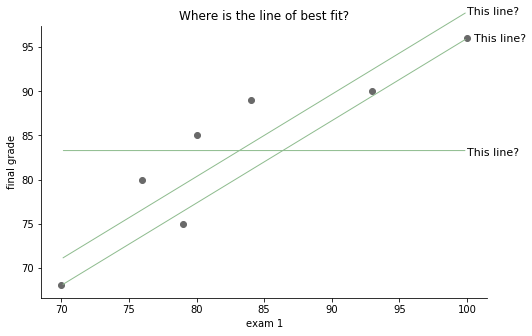

In [3]:
evaluation_example1(df, x, y)


Q1. How do we find the Line of Best Fit?

In [2]:
from statsmodels.formula.api import ols

ols_model = ols('y ~ x', data=df).fit()

df['yhat'] = ols_model.predict(pd.DataFrame(x))

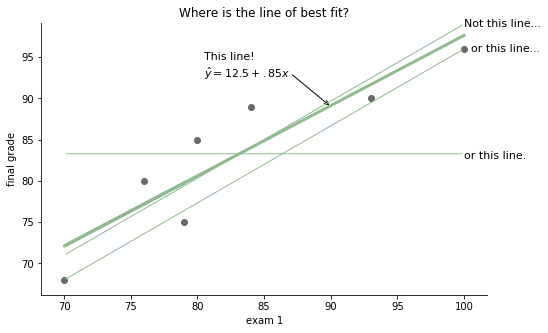

In [5]:
evaluation_example2(df, x, y)

**Q2. Is our model good enough?**

## Compute evaluation metrics for our model

In [9]:
# compute residuals
df['residual'] = df['yhat'] - df['y']

# square each residual value
# SUM OF SQUARED ERRORS (SSE OR RSS, RESIDUAL SUM OF SQUARES)
df['residual^2'] = df.residual ** 2
# SSE
SSE = sum(df['residual^2'])

print("SSE = ", SSE)

df.head(3)

SSE =  96.85259593679459


,x,y,yhat,residual,residual^2
0,100,96,97.635214,1.635214,2.673926
1,93,90,91.676524,1.676524,2.810732
2,84,89,84.015350,-4.984650,24.846737


In [10]:
from sklearn.metrics import mean_squared_error

SSE_function = mean_squared_error(df.y, df.yhat)*len(df)

print("SSE == SSE_function: ", SSE == SSE_function) 

SSE == SSE_function:  True


In [12]:
# mean squared error MSE
MSE = SSE/len(df)
print("MSE = ", MSE)
MSE_function = mean_squared_error(df.y, df.yhat)

print("MSE == MSE_function: ", MSE == MSE_function) 

MSE =  13.836085133827797
MSE == MSE_function:  True


In [15]:
# ROOT MEAN SQUARED ERROR (RMSE)
from math import sqrt
RMSE = sqrt(MSE)

print("RMSE = ", RMSE)

RMSE_function = sqrt(mean_squared_error(df.y, df.yhat))

print("RMSE == RMSE_function: ", RMSE == RMSE_function) 

RMSE =  3.7196888490608724
RMSE == RMSE_function:  True


In [16]:
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_eval['model_error'] = np.array([SSE, MSE, RMSE])
df_eval

,metric,model_error
0,SSE,96.852596
1,MSE,13.836085
2,RMSE,3.719689


## Compute evaluation metrics for a baseline model

Is the SSE value of 97.9 good? bad? ok? How do we know?

Our model should perform better than it would if I had no inputs (i.e. no data for exam 1).

In [17]:
# copy dataframe
df_baseline = df[['x','y']]
# compute the overall mean of the y values and add to 'yhat' as our prediction
df_baseline['yhat'] = df_baseline['y'].mean()

In [18]:
# compute the difference between y and yhat
df_baseline['residual'] = df_baseline['yhat'] - df_baseline['y']
# square that delta
df_baseline['residual^2'] = df_baseline['residual'] ** 2

df_baseline.head(3)

,x,y,yhat,residual,residual^2
0,100,96,83.285714,-12.714286,161.653061
1,93,90,83.285714,-6.714286,45.081633
2,84,89,83.285714,-5.714286,32.653061


In [19]:
SSE = sum(df_baseline['residual^2'])
print('SSE = ', SSE)
MSE = SSE/len(df)
print("MSE = ", MSE)
RMSE = sqrt(MSE)
print("RMSE = ", RMSE)

SSE =  555.4285714285714
MSE =  79.34693877551021
RMSE =  8.907689867497083


In [20]:
df_eval['baseline_error'] = np.array([SSE, MSE, RMSE])
df_eval['error_delta'] = df_eval.model_error - df_eval.baseline_error
df_eval

,metric,model_error,baseline_error,error_delta
0,SSE,96.852596,555.428571,-458.575975
1,MSE,13.836085,79.346939,-65.510854
2,RMSE,3.719689,8.907690,-5.188001


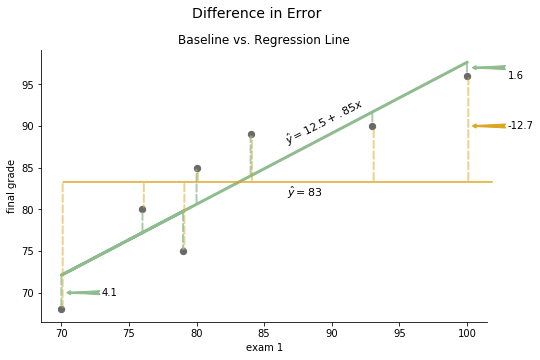

In [21]:
yhat = df.yhat
evaluation_example3(df, x, y, yhat)

## Coefficient of Determination and the F-test

$R^2$ is the ratio of the explained sum of squares (ESS) to the total sum of squares (TSS).


$R^2 * 100$ = Percent of variance in y (target) explained by x (feature)

The ESS (Explained Sum of Squares) predicted value -  μ of all actual grade

The TSS (Total Sum of Squares) is the difference between the actual final grade and the mean of all final grades. Also the total of ESS and SSE.


In [23]:
# compute explained sum of squares
ESS = sum((df.yhat - df.y.mean())**2)

SSE = df_eval[df_eval.metric=='SSE']['model_error']
TSS = ESS + SSE
print("ESS = ", ESS)
print("SSE = ", SSE[0])
print("TSS = ", TSS[0])

# add the ESS, SSE, TSS from the model to a dataframe
ss = pd.DataFrame(np.array(['SSE','ESS','TSS']), columns=['metric'])
ss['model_values'] = np.array([SSE[0], ESS, TSS[0]])

# compute and add the baseline values to the dataframe
ESS_baseline = sum((df_baseline.yhat - df.y.mean())**2)
SSE_baseline = df_eval[df_eval.metric=='SSE']['baseline_error']
TSS_baseline = ESS_baseline + SSE_baseline

ss['baseline_values'] = np.array([SSE_baseline[0], ESS_baseline, TSS_baseline[0]])

ss

ESS =  458.57597549177905
SSE =  96.85259593679459
TSS =  555.4285714285736


,metric,model_values,baseline_values
0,SSE,96.852596,555.428571
1,ESS,458.575975,0.000000
2,TSS,555.428571,555.428571


In [24]:
R2 = ESS/TSS[0]
print('R-squared = ',round(R2,3))
print("Percent of variance in y explained by x = ", round(R2*100,1), "%")

R-squared =  0.826
Percent of variance in y explained by x =  82.6 %


In [25]:
r2 = ols_model.rsquared
print('R-squared = ', round(r2,3))

R-squared =  0.826


In [26]:
evs = explained_variance_score(df.y, df.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.826


In [27]:
f_pval = ols_model.f_pvalue

print("p-value for model significance = ", round(f_pval,4))

p-value for model significance =  0.0046


**Q3: Are our features valuable?**

The T-test for feature significance
The null hypothesis states that the model without this variable fits the data as well as your model. (Significance > 0.05)

The alternative hypothesis says that your model fits the data better with that independent variable than the model without that variable (Significance F <= 0.05)

In [28]:
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     23.67
Date:                Sat, 12 Oct 2019   Prob (F-statistic):            0.00461
Time:                        20:20:36   Log-Likelihood:                -19.128
No. Observations:                   7   AIC:                             42.26
Df Residuals:                       5   BIC:                             42.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.5111     14.641      0.855      0.432     -25.124      50.146
x              0.8512      0.175      4.866      0.005       0.402       1.301
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.983
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.776
Skew:                           0.124   Prob(JB):                        0.678
Kurtosis:                       1.388   Cond. No.                         737.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Q4. How much confidence do we have in our results?**

**Exercise**

Load the tips dataset from either pydataset or seaborn.


Write a function, regression_errors(y, yhat), that takes in y and yhat, returns the sum of squared errors (SSE), explained sum of squares (ESS), total sum of squares (TSS), mean squared error (MSE) and root mean squared error (RMSE).

Write a function, baseline_mean_errors(y), that takes in your target, y, computes the SSE, MSE & RMSE when yhat is equal to the mean of all y, and returns the error values (SSE, MSE, and RMSE).

Write a function, better_than_baseline(SSE), that returns true if your model performs better than the baseline, otherwise false.

Write a function, model_significance(ols_model), that takes the ols model as input and returns the amount of variance explained in your model, and the value telling you whether the correlation between the model and the tip value are statistically significant.

In [8]:
from pydataset import data

In [38]:
tip = data("tips")

In [40]:
tip.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [42]:
tip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 1 to 244
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null object
smoker        244 non-null object
day           244 non-null object
time          244 non-null object
size          244 non-null int64
dtypes: float64(2), int64(1), object(4)
memory usage: 15.2+ KB


In [12]:
# find the Line of Best Fit?

In [13]:
from statsmodels.formula.api import ols

In [43]:
# x = df[['total_bill']]
# y = df[['tip']]

# tip.tip as the target
x = df.total_bill
y = df.tip

# use linear regression model (ordinary least squares) to computre yhat 
# predictions of tip using total_bill
ols_model = ols('y~x', data = df).fit()
df["yhat"] = ols_model.predict(pd.DataFrame(x))


In [44]:
tip.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


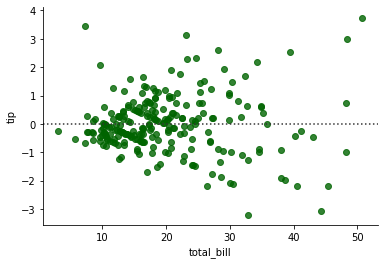

In [45]:
# feature, the target, and the dataframe as input and returns a residual plot.

# Import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# function takes in the feature, target, data_source to generate residual plot using sns
def plot_residuals(x, y, df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.residplot(x, y, data = df, color = "darkgreen")
plot_residuals(tip.total_bill, tip.tip, tip)

**From y and yhat, compute evaluation metrics**

- sum of squared errors (SSE)

- explained sum of squares (ESS)

- total sum of squares (TSS)

- mean squared error (MSE) 

- root mean squared error (RMSE)

SSE =  252.78874385077603


,total_bill,tip,sex,smoker,day,time,size,yhat,residual
1,16.99,1.01,Female,No,Sun,Dinner,2,2.704636,1.694636
2,10.34,1.66,Male,No,Sun,Dinner,3,2.006223,0.346223
3,21.01,3.50,Male,No,Sun,Dinner,3,3.126835,-0.373165
4,23.68,3.31,Male,No,Sun,Dinner,2,3.407250,0.097250
5,24.59,3.61,Female,No,Sun,Dinner,4,3.502822,-0.107178


In [8]:
# Manual

# SSE sum(residual, aka dif between predict & actual)
# USE: when outliers matter
tip['residual'] = tip['yhat'] - tip['tip']
SSE = sum((tip['residual']) ** 2)

from sklearn.metrics import mean_squared_error

SSE_function = mean_squared_error(tip.tip, tip.yhat)*len(tip) # import function to calc SSE
print("Manual_SSE:", SSE)
print("Function_SSE:", SSE_function)

# mean of SSE: SSE / n
# USE: outliers don't matter as much
# cost exponential instead of linear

# a case of residual = 10 (predict - actual)  bettern than 2 cases of prediction off by 5 when compared with actual
MSE = SSE/len(tip)
print("MSE = ", MSE)

# USE: to observe error in the actual units of the y variable,
from math import sqrt
RMSE = sqrt(MSE)
RMSE_function = sqrt(mean_squared_error(tip.tip, tip.yhat)) # import function to calc SSE
print("Manual_RMSE:", RMSE)
print("Function_RMSE = ", RMSE_function)

# compare w/ baseline, if not better, no need model, just rely on mean or median

# copy dataframe
df_baseline = df[['x','y']]
# compute the overall mean of the y values and add to 'yhat' as our prediction
df_baseline['yhat'] = df_baseline['y'].mean()

# SSE_baseline
# compute the difference between y and yhat
df_baseline['residual'] = df_baseline['yhat'] - df_baseline['y']
# calc SSE_baseline from residual
SSE_baseline = sum(df_baseline.residual ** 2)
# MSE_baseline
MSE_baseline = SSE_baseline/len(df_baseline)
# RMSE_baseline
RMSE_baseline = sqrt(MSE_baseline)

# create dataframe holding summary
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_eval['model_error'] = np.array([SSE, MSE, RMSE])

df_eval['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
df_eval['error_delta'] = df_eval.model_error - df_eval.baseline_error
df_eval

# compute explained sum of squares
ESS = sum((df.yhat - df.y.mean())**2)

SSE = df_eval[df_eval.metric=='SSE']['model_error']
TSS = ESS + SSE



SyntaxError: invalid syntax (<ipython-input-8-f995f946f3c3>, line 22)

In [46]:
def regression_errors(x, y, df):
    from statsmodels.formula.api import ols
    # fit linear model
    linear = ols('y~x', data = df).fit()
    # prediction of yhat based on x
    df["yhat"] = linear.predict(pd.DataFrame(x))
    # calc residual =  predict - reality = yhat - y
    df['residual'] = df['yhat'] - y
    # calc SSE, sum(residual^2)
    SSE = sum((df['residual']) ** 2)
    # mean = all result / sample number = SSE/n
    MSE = SSE/ len(df)
    from math import sqrt
    RMSE = sqrt(MSE)
    ESS = sum((df['yhat'] - y.mean())**2)
    TSS = ESS + SSE
    print("SSE: ", SSE, "MSE: ", MSE, "RMSE: ", RMSE)
    return SSE, MSE, RMSE, ESS, TSS
regression_errors(tip.total_bill, tip.tip, tip)

SSE:  252.78874385077603 MSE:  1.036019442011377 RMSE:  1.0178504025697377


(252.78874385077603,
 1.036019442011377,
 1.0178504025697377,
 212.4237331984042,
 465.2124770491802)

In [48]:
def baseline_mean_errors(y,df):
    # compare w/ baseline, if not better, no need model, just rely on mean or median
    # copy dataframe
    df_baseline = pd.DataFrame(y)
    # compute the overall mean of the y values and add to 'yhat' as our prediction
    df_baseline['yhat'] = df_baseline.tip.mean()
    
    # SSE_baseline
    # compute the difference between y and yhat
    df_baseline['residual'] = df_baseline['yhat'] - df_baseline.tip
    # calc SSE_baseline from residual
    SSE_baseline = sum(df_baseline.residual ** 2)
    # MSE_baseline
    MSE_baseline = SSE_baseline/len(df_baseline)
    # RMSE_baseline
    RMSE_baseline = sqrt(MSE_baseline)
    
    print("SSE_base: ", SSE_baseline, "MSE_base: ", MSE_baseline, "RMSE_base: ", RMSE_baseline)
    return SSE_baseline, MSE_baseline, RMSE_baseline
baseline_mean_errors(tip.tip, tip)

SSE_base:  465.21247704918085 MSE_base:  1.9066085124966428 RMSE_base:  1.3807999538298958


(465.21247704918085, 1.9066085124966428, 1.3807999538298958)

SSE:  252.78874385077603 MSE:  1.036019442011377 RMSE:  1.0178504025697377


252.78874385077603

In [49]:
def better_than_baseline(x,y):

    # create dataframe holding summary
    df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
    df_eval['model_error'] = np.array([x[0], x[1], x[2]])

    df_eval['baseline_error'] = np.array([y[0], y[1], y[2]])
    df_eval['error_delta'] = df_eval.model_error - df_eval.baseline_error
    print(df_eval)
    print(x[0], y[0])
    
    if x[0] < y[0]:
        return True
    else:
        False
better_than_baseline(regression_errors(tip.total_bill, tip.tip, tip),baseline_mean_errors(tip.tip, tip))

SSE:  252.78874385077603 MSE:  1.036019442011377 RMSE:  1.0178504025697377
SSE_base:  465.21247704918085 MSE_base:  1.9066085124966428 RMSE_base:  1.3807999538298958
  metric  model_error  baseline_error  error_delta
0    SSE   252.788744      465.212477  -212.423733
1    MSE     1.036019        1.906609    -0.870589
2   RMSE     1.017850        1.380800    -0.362950
252.78874385077603 465.21247704918085


True

Write a function, model_significance(ols_model), 
that takes the ols model as input and 
returns the amount of variance explained in your model, 

and the value telling you whether the correlation between the model and the tip value are statistically significant.

In [32]:
def model_significance(x,y,df):
    from statsmodels.formula.api import ols
    x = tip.total_bill
    y = tip.tip
    # fit linear model
    linear = ols('y~x', data = df).fit()
    r2 = linear.rsquared
    print('R-squared = ', round(r2,3))
    f_pval = linear.f_pvalue

    print("p-value for model significance = ", round(f_pval))
    return linear.summary()
model_significance(tip.total_bill, tip.tip, tip)

R-squared =  0.457
p-value for model significance =  0.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     203.4
Date:                Sun, 13 Oct 2019   Prob (F-statistic):           6.69e-34
Time:                        17:48:03   Log-Likelihood:                -350.54
No. Observations:                 244   AIC:                             705.1
Df Residuals:                     242   BIC:                             712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9203      0.160      5.761      0.000       0.606       1.235
x              0.1050      0.007     14.260      0.000       0.091       0.120
==============================================================================
Omnibus:                       20.185   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.750
Skew:                           0.443   Prob(JB):                     6.35e-09
Kurtosis:                       4.711   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

understand the strength of the relationship between the model and the dependent variable using the Coefficient of Determination, the F-test to test the value's significance, and the resulting p-value (probability that the relationship is due to chance)

$R^2$ - how well your model fits the data, measure strength of the relationship between model & dependent variable

**F-test of overall significance, w/ p-value**
>hypothesis test,  whether linear regression model provides a better fit to the data than a model w/o independent variables.
>
> If overall F-test is significant (evident through the p-value of the F statistic, 
> Conclude: $R^2 \neq 0$ & correlation between the model and dependent variable is statistically significant.
>
> $R^2$: ratio of the explained sum of squares (ESS) to the total sum of squares (TSS).
```python
ESS = sum((df.yhat - df.y.mean())**2)

df['residual'] = df['yhat'] - y
# calc SSE, sum(residual^2)
SSE = sum((df['residual']) ** 2)

TSS = ESS + SSE
```

The ESS (Explained Sum of Squares) is the difference between the predicted final grade and the mean of all final grades.

The TSS (Total Sum of Squares) is the difference between the actual final grade and the mean of all final grades. Also the total of ESS and SSE.
```python
# add the ESS, SSE, TSS from the model to a dataframe
ss = pd.DataFrame(np.array(['SSE','ESS','TSS']), columns=['metric'])
ss['model_values'] = np.array([SSE[0], ESS, TSS[0]])

# compute and add the baseline values to the dataframe
ESS_baseline = sum((df_baseline.yhat - df.y.mean())**2)
SSE_baseline = df_eval[df_eval.metric=='SSE']['baseline_error']
TSS_baseline = ESS_baseline + SSE_baseline

ss['baseline_values'] = np.array([SSE_baseline[0], ESS_baseline, TSS_baseline[0]])
ss

R2 = ESS/TSS[0]
print('R-squared = ',round(R2,3))
print("Percent of variance in y explained by x = ", round(R2*100,1), "%")

r2 = ols_model.rsquared = evs = explained_variance_score(df.y, df.yhat)
```


